In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import itertools
from os import listdir
import uproot
import awkward as ak
from sklearn.model_selection import train_test_split

import matplotlib as mpl

from datetime import datetime
import subprocess
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model, Sequential
import omnifold as of
import os
import tensorflow as tf
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine, net
from omnifold.net import weighted_binary_crossentropy
#import energyflow as ef

from IPython.display import Image

os.environ['CUDA_VISIBLE_DEVICES']="2" #odslserv 0123 überprüfen
has_gpu=True

from pickle import dump

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="2"
    physical_devices = tf.config.list_physical_devices('GPU') 
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu, True)

2025-04-24 09:48:26.033423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-24 09:48:26.638158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745480906.826990  374814 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745480906.873198  374814 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745480907.376228  374814 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Horovod not found, will continue with single only GPUs.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
real_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/tree/TN_WbWb_SR_Whad_Final_Nominal_data.root'
reco_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/tree/TN_WbWb_SR_Whad_Final_Nominal_ttbar_enhanced.root'
truth_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/tree/TN_WbWb_SR_Whad_Final_Nominal_ttbar_enhanced_truth.root'
herwig_data = '/scratch/mjosef/OMNIFOLD_Tutorial/datasets/tree/ttbar_enhanced_Herwig71_fast.Nominal.root'

real_file = uproot.open(real_data)
real_tree = real_file['NOSYS/physics']

reco_file = uproot.open(reco_data)
reco_tree = reco_file['NOSYS/matched_Whad_particle;2']

truth_file = uproot.open(truth_data)
truth_tree = truth_file['NOSYS/physics']

herwig_file = uproot.open(herwig_data)
herwig_tree = herwig_file['NOSYS/matched_Whad_particle']

real_array = real_tree.arrays()
reco_array = reco_tree.arrays()
truth_array = truth_tree.arrays()
herwig_array = herwig_tree.arrays()

In [6]:
# sim
theta0_S = np.column_stack((reco_array['ptl1'], reco_array['ptb1'], reco_array['ptb2'], reco_array['ptj1'], reco_array['dRbl_selected'], reco_array['mbl_selected'])).to_numpy()
theta0_G = np.column_stack((reco_array['truth_ptl1'], reco_array['truth_ptb1'], reco_array['truth_ptb2'], reco_array['truth_ptj1'], reco_array['truth_dR_particlebl'], reco_array['truth_m_particlebl'])).to_numpy()
weights_reco = reco_array['eventWeight'].to_numpy()
weights_gen = herwig_array['eventWeight'].to_numpy()
weights_data = real_array['eventWeight'].to_numpy()

# 'data'
theta_data = np.column_stack((real_array['ptl1'], real_array['ptb1'], real_array['ptb2'], real_array['ptj1'], real_array['dRbl_selected'], real_array['mbl_selected'])).to_numpy()
theta_unknown_S = np.column_stack((herwig_array['ptl1'], herwig_array['ptb1'], herwig_array['ptb2'], herwig_array['ptj1'], herwig_array['dRbl_selected'], herwig_array['mbl_selected'])).to_numpy()
theta_unknown_G = np.column_stack((herwig_array['truth_ptl1'], herwig_array['truth_ptb1'], herwig_array['truth_ptb2'], herwig_array['truth_ptj1'], herwig_array['truth_dR_particlebl'], herwig_array['truth_m_particlebl'])).to_numpy()
print(theta0_S.shape, theta0_G.shape, theta_unknown_S.shape, theta_unknown_G.shape, theta_data.shape)

(9847418, 6) (9847418, 6) (2794446, 6) (2794446, 6) (848818, 6)


In [4]:
theta_unknown_S_train, theta_unknown_S_test, theta_unknown_G_train, theta_unknown_G_test = train_test_split(theta_unknown_S, theta_unknown_G, test_size=0.33)

In [7]:
theta_data_train, theta_data_test, data_weights_train, data_weights_test = train_test_split(theta_data, weights_data, test_size=0.33)

In [8]:
weights_gen_train, weights_gen_test = train_test_split(weights_gen, test_size=0.33)

In [9]:
data = DataLoader(reco = theta_data_train, weight = data_weights_train, normalize=True)
mc = DataLoader(reco = theta0_S, gen = theta0_G, weight = weights_reco, normalize=True)

INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


(<Figure size 900x900 with 2 Axes>,
 <Axes: ylabel='Normalized number of events'>)

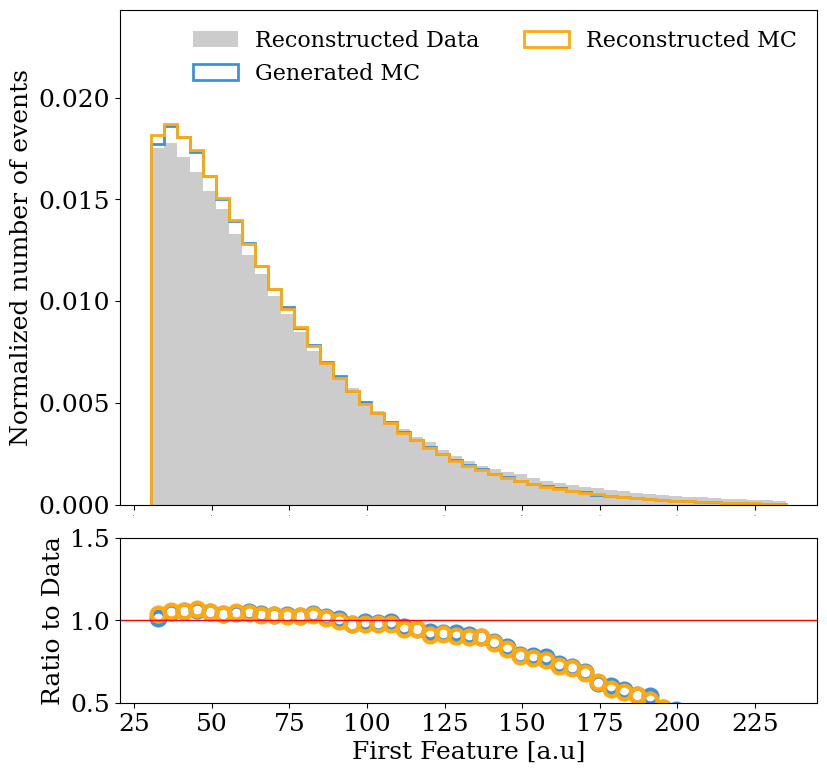

In [11]:
SetStyle()
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:,0],
    'Reconstructed Data': theta_data_train[:,0],
    'Generated MC': theta0_G[:1872278,0],
    'Reconstructed MC': theta0_S[:1872278,0],
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'Reconstructed Data',plot_ratio=True)

In [12]:
ndim = 6 #The number of features present in your dataset
reco_model = MLP(ndim)
gen_model = MLP(ndim)

I0000 00:00:1745481338.146013  374814 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 140842 MB memory:  -> device: 0, name: NVIDIA H200, pci bus id: 0000:43:00.0, compute capability: 9.0


In [13]:
omnifold = MultiFold(
    "WWbb",
    reco_model,
    gen_model,
    data,
    mc,
    batch_size = 2048,
    niter = 3,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights_real-data',
    verbose = True,
    lr = 5e-5,
)

5085 training steps at reco and 9616 steps at gen


In [14]:
import keras

@keras.saving.register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    t_loss = weights*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    return tf.reduce_mean(t_loss)

In [15]:
%%time
omnifold.Unfold()

ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 10414080, Test events used: 2082815
################################################################################
Epoch 1/100


2025-04-24 09:56:15.223608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:4,RepeatDataset:5): Filling up shuffle buffer (this may take a while): 4988774 of 8331265
2025-04-24 09:56:22.143279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
I0000 00:00:1745481382.152605  376121 service.cc:152] XLA service 0x7f270c003e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745481382.152643  376121 service.cc:160]   StreamExecutor device (0): NVIDIA H200, Compute Capability 9.0
2025-04-24 09:56:22.210883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745481382.453886  376121 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1745481383.203457  376121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifeti

4068/4068 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 0.1468 - val_loss: 0.1330 - learning_rate: 5.0000e-05
Epoch 2/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - loss: 0.1330 - val_loss: 0.1326 - learning_rate: 5.0000e-05
Epoch 3/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1329 - val_loss: 0.1327 - learning_rate: 5.0000e-05
Epoch 4/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1327 - val_loss: 0.1328 - learning_rate: 5.0000e-05
Epoch 5/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1324 - val_loss: 0.1323 - learning_rate: 5.0000e-05
Epoch 6/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1325 - val_loss: 0.1322 - learning_rate: 5.0000e-05
Epoch 7/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1325 - val_loss: 0.1323 - learning_rate: 5.0000e-05
Epoch 8/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1324 - val_loss: 0.1322 - learning_rate: 5.0000e-05
Epoch 9/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - l

9848/9848 ━━━━━━━━━━━━━━━━━━━━ 7s 722us/step


/afs/ipp-garching.mpg.de/home/m/mjosef/.local/lib/python3.12/site-packages/omnifold/omnifold.py:33: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))


RUNNING STEP 2
Creating cached data from step 2
################################################################################
Train events used: 19693568, Test events used: 3938713
################################################################################
Epoch 1/100


2025-04-24 10:41:56.226622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:33,RepeatDataset:34): Filling up shuffle buffer (this may take a while): 4946869 of 15754855
2025-04-24 10:42:06.226619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:33,RepeatDataset:34): Filling up shuffle buffer (this may take a while): 9756517 of 15754855
2025-04-24 10:42:16.226619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:33,RepeatDataset:34): Filling up shuffle buffer (this may take a while): 14539862 of 15754855
2025-04-24 10:42:18.883788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


7692/7692 ━━━━━━━━━━━━━━━━━━━━ 133s 13ms/step - loss: 0.0844 - val_loss: 0.0700 - learning_rate: 5.0000e-05
Epoch 2/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 113s 15ms/step - loss: 0.0700 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 3/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 4/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 5/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 6/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0698 - val_loss: 0.0698 - learning_rate: 5.0000e-05
Epoch 7/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0698 - val_loss: 0.0698 - learning_rate: 5.0000e-05
Epoch 8/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0698 - val_loss: 0.0698 - learning_rate: 5.0000e-05
Epoch 9/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms

7692/7692 ━━━━━━━━━━━━━━━━━━━━ 89s 12ms/step - loss: 0.0696 - val_loss: 0.0697 - learning_rate: 5.0000e-05
Epoch 55/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.0696 - val_loss: 0.0697 - learning_rate: 5.0000e-05
Epoch 56/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 0.0696 - val_loss: 0.0697 - learning_rate: 5.0000e-05
Epoch 57/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 85s 11ms/step - loss: 0.0696 - val_loss: 0.0697 - learning_rate: 5.0000e-05
Epoch 58/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 87s 11ms/step - loss: 0.0696 - val_loss: 0.0696 - learning_rate: 5.0000e-05
Epoch 59/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 86s 11ms/step - loss: 0.0696 - val_loss: 0.0696 - learning_rate: 5.0000e-05
Epoch 60/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 84s 11ms/step - loss: 0.0696 - val_loss: 0.0696 - learning_rate: 5.0000e-05
Epoch 61/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 83s 11ms/step - loss: 0.0696 - val_loss: 0.0697 - learning_rate: 5.0000e-05
Epoch 62/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 82s 11ms/

2025-04-24 12:50:00.601945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:61,RepeatDataset:62): Filling up shuffle buffer (this may take a while): 4953795 of 8331265
2025-04-24 12:50:07.643000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4068/4068 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - loss: 0.1326 - val_loss: 0.1325 - learning_rate: 5.0000e-05
Epoch 2/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - loss: 0.1327 - val_loss: 0.1326 - learning_rate: 5.0000e-05
Epoch 3/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1326 - val_loss: 0.1325 - learning_rate: 5.0000e-05
Epoch 4/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 59s 14ms/step - loss: 0.1326 - val_loss: 0.1326 - learning_rate: 5.0000e-05
Epoch 5/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1325 - val_loss: 0.1327 - learning_rate: 5.0000e-05
Epoch 6/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1322 - val_loss: 0.1324 - learning_rate: 5.0000e-05
Epoch 7/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1325 - val_loss: 0.1326 - learning_rate: 5.0000e-05
Epoch 8/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1325 - val_loss: 0.1325 - learning_rate: 5.0000e-05
Epoch 9/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - l

2025-04-24 13:05:06.889534: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:89,RepeatDataset:90): Filling up shuffle buffer (this may take a while): 4919553 of 15754855
2025-04-24 13:05:16.889538: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:89,RepeatDataset:90): Filling up shuffle buffer (this may take a while): 9624123 of 15754855
2025-04-24 13:05:26.889530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:89,RepeatDataset:90): Filling up shuffle buffer (this may take a while): 14436289 of 15754855
2025-04-24 13:05:29.799450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


7692/7692 ━━━━━━━━━━━━━━━━━━━━ 133s 13ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 2/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 111s 14ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 3/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 4/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 5/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 6/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 7/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 117s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 8/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 117s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 9/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms

2025-04-24 13:42:21.454962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:117,RepeatDataset:118): Filling up shuffle buffer (this may take a while): 4897667 of 8331265
2025-04-24 13:42:28.670985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


4068/4068 ━━━━━━━━━━━━━━━━━━━━ 69s 12ms/step - loss: 0.1337 - val_loss: 0.1335 - learning_rate: 5.0000e-05
Epoch 2/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - loss: 0.1336 - val_loss: 0.1335 - learning_rate: 5.0000e-05
Epoch 3/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - loss: 0.1336 - val_loss: 0.1337 - learning_rate: 5.0000e-05
Epoch 4/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1336 - val_loss: 0.1336 - learning_rate: 5.0000e-05
Epoch 5/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1336 - val_loss: 0.1338 - learning_rate: 5.0000e-05
Epoch 6/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1335 - val_loss: 0.1336 - learning_rate: 5.0000e-05
Epoch 7/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1336 - val_loss: 0.1338 - learning_rate: 5.0000e-05
Epoch 8/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 58s 14ms/step - loss: 0.1336 - val_loss: 0.1336 - learning_rate: 5.0000e-05
Epoch 9/100
4068/4068 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - l

2025-04-24 13:54:17.311631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:145,RepeatDataset:146): Filling up shuffle buffer (this may take a while): 4958000 of 15754855
2025-04-24 13:54:27.311630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:145,RepeatDataset:146): Filling up shuffle buffer (this may take a while): 9677080 of 15754855
2025-04-24 13:54:37.311609: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] fused(ShuffleDatasetV3:145,RepeatDataset:146): Filling up shuffle buffer (this may take a while): 14508360 of 15754855
2025-04-24 13:54:40.041009: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


7692/7692 ━━━━━━━━━━━━━━━━━━━━ 131s 13ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 2/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 114s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 3/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 114s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 4/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 5/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0699 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 6/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 116s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 7/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 8/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms/step - loss: 0.0698 - val_loss: 0.0699 - learning_rate: 5.0000e-05
Epoch 9/100
7692/7692 ━━━━━━━━━━━━━━━━━━━━ 115s 15ms

In [16]:
unfolded_weights  = omnifold.reweight(theta_data_test,omnifold.model2,batch_size=1000)

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [17]:
print(unfolded_weights)

[0.80901831 0.95013529 1.05140865 ... 1.04329181 1.4978838  0.96661168]


In [59]:
import h5py

# Open the file in read mode
with h5py.File('weights_real-data/OmniFold_WWbb_iter2_step2.weights.h5', 'r') as f:
    # Print all root level groups and datasets
    print("Keys: %s" % f.keys())
    
    # Access a specific dataset (example)
    loaded_data = f['vars'].value
    print(loaded_data)

Keys: <KeysViewHDF5 ['layers', 'optimizer', 'vars']>


AttributeError: 'Group' object has no attribute 'value'

In [55]:
s = h5py.File('weights_real-data/OmniFold_WWbb_iter2_step2.weights.h5','r')
s

<HDF5 file "OmniFold_WWbb_iter2_step2.weights.h5" (mode r)>

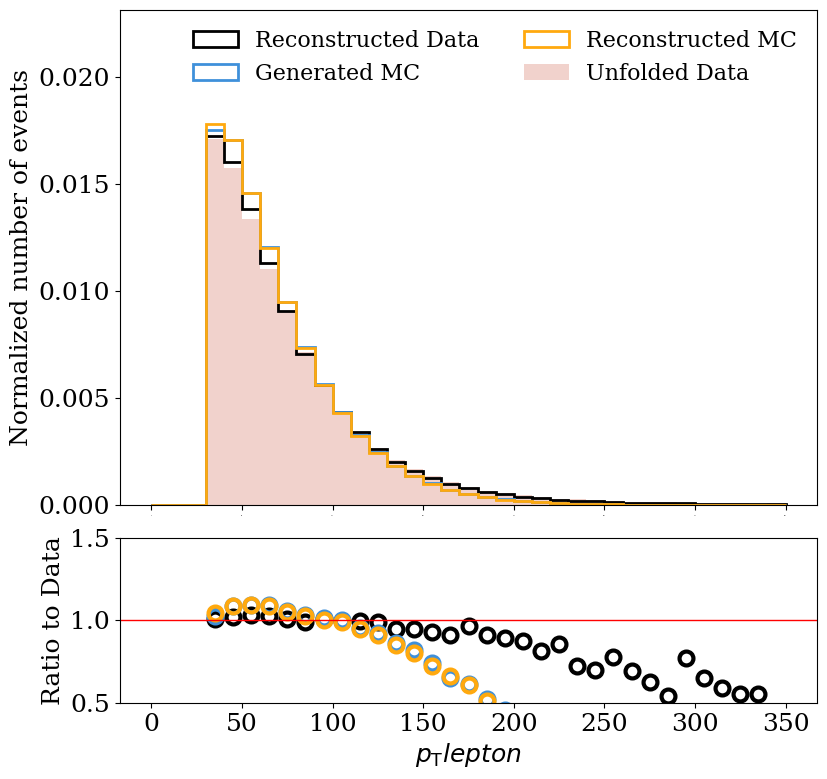

In [43]:
binning = [ #simple plotting bins
np.linspace(0, 350, 36),   #lepton pT
np.linspace(0, 400, 41),     #leading bjet pT
np.linspace(0, 300, 31),  #subleading bjet pT
np.linspace(0, 500, 51),    #leading jet pT
np.linspace(0, 6, 31),    # dR(bl)
np.linspace(0, 850, 86)]     # mass(bl)

labels = [
    r"$p_\mathrm{T}lepton$",
    r"$p_\mathrm{T}b1$",
    r"$p_\mathrm{T}b2$",
    r"$p_\mathrm{T}jet$",
    r"$\Delta R_\mathrm{bl}$",
    r"$m_\mathrm{bl}$"]

index= 0
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:922168,index],
    'Reconstructed Data': theta_data_train[:data.reco.shape[0],index],
    'Generated MC': theta0_G[:data.reco.shape[0],index],
    'Reconstructed MC': theta0_S[:data.reco.shape[0],index],
    'Unfolded Data': theta_data_test[:,index],
}

weight_dict = {
        #'Truth Distribution': np.ones_like(data_dict['Truth Distribution']),
        'Reconstructed Data': np.ones_like(data_dict['Reconstructed Data']),
        'Generated MC': np.ones_like(data_dict['Generated MC']),
        'Reconstructed MC': np.ones_like(data_dict['Reconstructed MC']),
        'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,labels[index],
                    reference_name = 'Unfolded Data',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = binning[index]
                    )

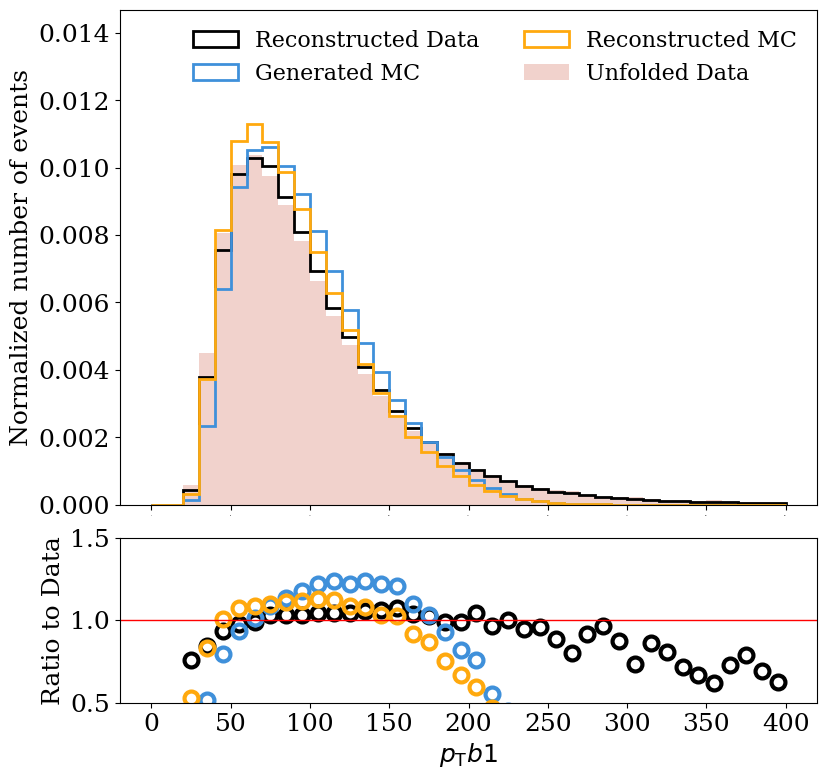

In [39]:
index= 1
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:922168,index],
    'Reconstructed Data': theta_data_train[:data.reco.shape[0],index],
    'Generated MC': theta0_G[:data.reco.shape[0],index],
    'Reconstructed MC': theta0_S[:data.reco.shape[0],index],
    'Unfolded Data': theta_data_test[:,index],
}

weight_dict = {
        #'Truth Distribution': np.ones_like(data_dict['Truth Distribution']),
        'Reconstructed Data': np.ones_like(data_dict['Reconstructed Data']),
        'Generated MC': np.ones_like(data_dict['Generated MC']),
        'Reconstructed MC': np.ones_like(data_dict['Reconstructed MC']),
        'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,labels[index],
                    reference_name = 'Unfolded Data',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = binning[index]
                    )

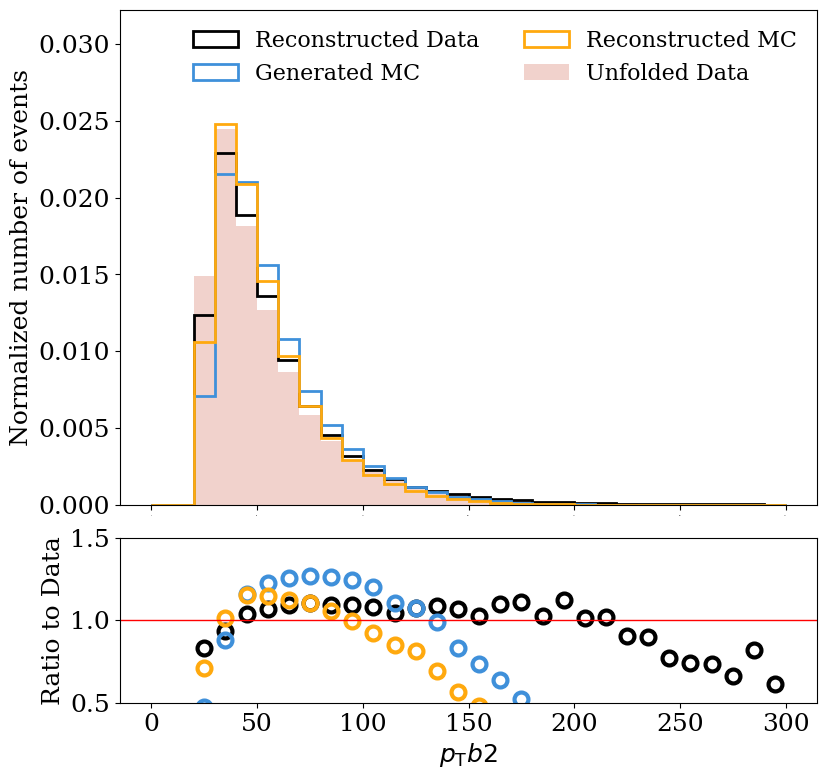

In [40]:
index= 2
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:922168,index],
    'Reconstructed Data': theta_data_train[:data.reco.shape[0],index],
    'Generated MC': theta0_G[:data.reco.shape[0],index],
    'Reconstructed MC': theta0_S[:data.reco.shape[0],index],
    'Unfolded Data': theta_data_test[:,index],
}

weight_dict = {
        #'Truth Distribution': np.ones_like(data_dict['Truth Distribution']),
        'Reconstructed Data': np.ones_like(data_dict['Reconstructed Data']),
        'Generated MC': np.ones_like(data_dict['Generated MC']),
        'Reconstructed MC': np.ones_like(data_dict['Reconstructed MC']),
        'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,labels[index],
                    reference_name = 'Unfolded Data',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = binning[index]
                    )

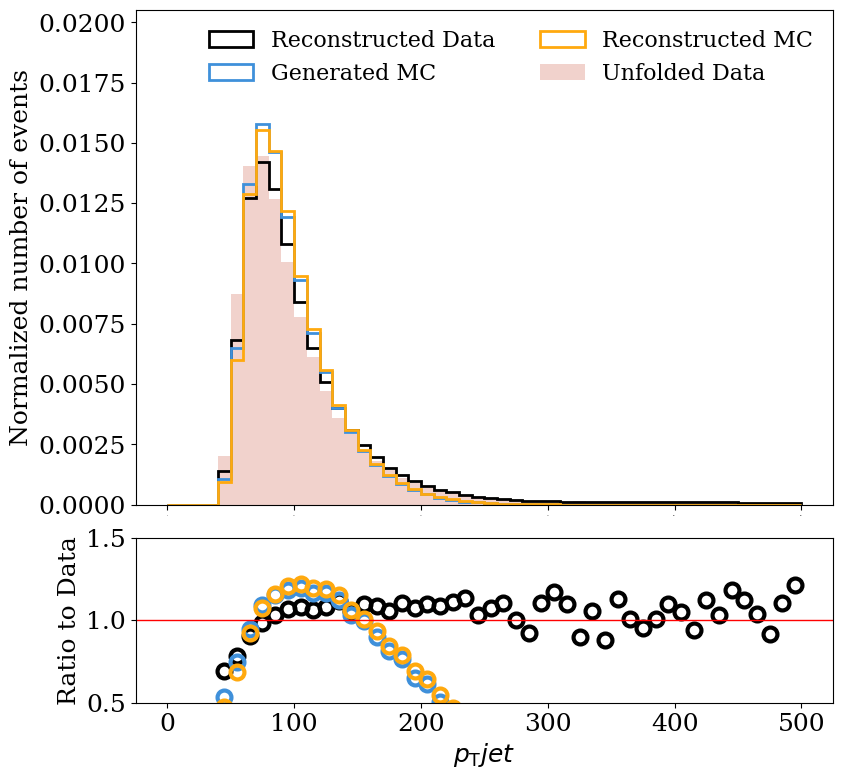

In [41]:
index= 3
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:922168,index],
    'Reconstructed Data': theta_data_train[:data.reco.shape[0],index],
    'Generated MC': theta0_G[:data.reco.shape[0],index],
    'Reconstructed MC': theta0_S[:data.reco.shape[0],index],
    'Unfolded Data': theta_data_test[:,index],
}

weight_dict = {
        #'Truth Distribution': np.ones_like(data_dict['Truth Distribution']),
        'Reconstructed Data': np.ones_like(data_dict['Reconstructed Data']),
        'Generated MC': np.ones_like(data_dict['Generated MC']),
        'Reconstructed MC': np.ones_like(data_dict['Reconstructed MC']),
        'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,labels[index],
                    reference_name = 'Unfolded Data',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = binning[index]
                    )

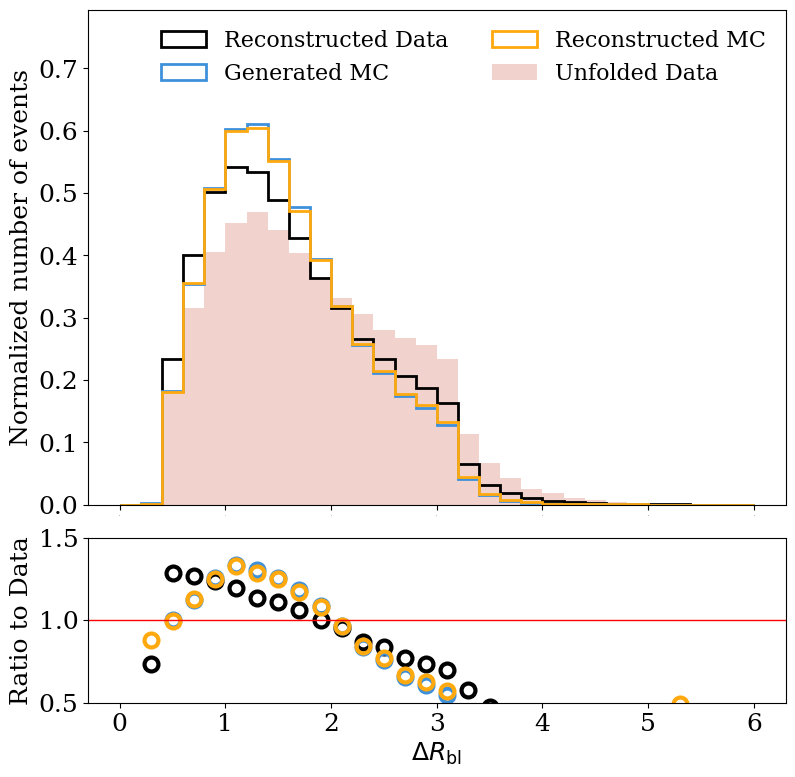

In [44]:
index= 4
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:922168,index],
    'Reconstructed Data': theta_data_train[:data.reco.shape[0],index],
    'Generated MC': theta0_G[:data.reco.shape[0],index],
    'Reconstructed MC': theta0_S[:data.reco.shape[0],index],
    'Unfolded Data': theta_data_test[:,index],
}

weight_dict = {
        #'Truth Distribution': np.ones_like(data_dict['Truth Distribution']),
        'Reconstructed Data': np.ones_like(data_dict['Reconstructed Data']),
        'Generated MC': np.ones_like(data_dict['Generated MC']),
        'Reconstructed MC': np.ones_like(data_dict['Reconstructed MC']),
        'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,labels[index],
                    reference_name = 'Unfolded Data',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = binning[index]
                    )

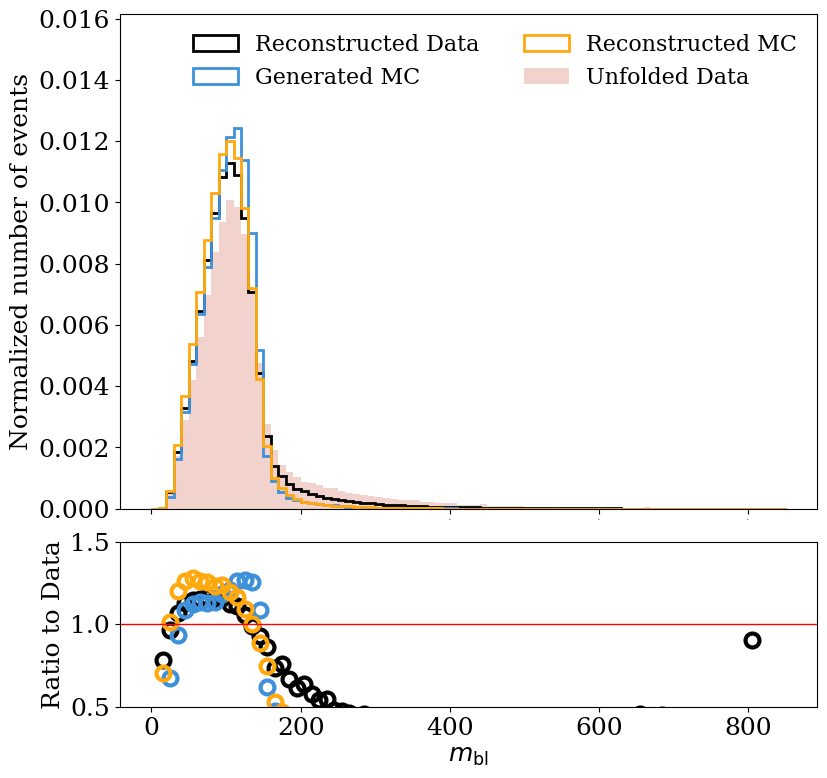

In [45]:
index= 5
data_dict = {
    #'Truth Distribution': theta_unknown_G_train[:922168,index],
    'Reconstructed Data': theta_data_train[:data.reco.shape[0],index],
    'Generated MC': theta0_G[:data.reco.shape[0],index],
    'Reconstructed MC': theta0_S[:data.reco.shape[0],index],
    'Unfolded Data': theta_data_test[:,index],
}

weight_dict = {
        #'Truth Distribution': np.ones_like(data_dict['Truth Distribution']),
        'Reconstructed Data': np.ones_like(data_dict['Reconstructed Data']),
        'Generated MC': np.ones_like(data_dict['Generated MC']),
        'Reconstructed MC': np.ones_like(data_dict['Reconstructed MC']),
        'Unfolded Data': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,labels[index],
                    reference_name = 'Unfolded Data',
                    weights = weight_dict,
                    plot_ratio = True,
                    binning = binning[index]
                    )